# 因子回测

## 导入模块

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
from scipy import stats
import feather
import os
import statsmodels.api as sm
import sunlandsdatasdk as sd

## 读入日线数据

### 读入日线数据

In [2]:
price_1d = feather.read_dataframe('../data/StockPriceK1d_20241231.feather')

### 计算调仓日

In [3]:
trade_date = price_1d['date'].sort_values().unique()
start_date = '2019-01-01'
end_date = '2025-01-01'
mes = pd.date_range(start=start_date, end=end_date, freq='1ME')
adj_date = np.array([], dtype=np.datetime64)
for me in mes:
    trade_date_before = trade_date[trade_date <= me]
    ad = trade_date_before[-1]
    adj_date = np.append(adj_date, ad)
map_mon_adj = {ad.year * 100 + ad.month: ad for ad in adj_date}

### 计算每两个调仓日之间的收益

In [4]:
price_1d['year_mon'] = price_1d['date'].dt.year * 100 + price_1d['date'].dt.month

def ret_acc_prod(price_1d):
    ret = price_1d['ret']
    return (1 + ret).prod() - 1

def ret_acc_adj(price_1d):
    preclose = price_1d.iloc[0]['preclose'] * price_1d.iloc[0]['adj']
    close = price_1d.iloc[-1]['close'] * price_1d.iloc[-1]['adj']
    return (close - preclose) / preclose

def ret_acc(price_1d):
    preclose = price_1d.iloc[0]['preclose']
    close = price_1d.iloc[-1]['close']
    return (close - preclose) / preclose

price_adj = (
    price_1d[(price_1d['date'] >= start_date) & (price_1d['date'] <= end_date)]
        .groupby(['issue', 'year_mon'])[['preclose', 'close', 'adj', 'ret']]
        .apply(ret_acc_prod)
        .reset_index()
)
price_adj = price_adj.rename(columns={0: 'ret'})
price_adj['date'] = price_adj['year_mon'].apply(map_mon_adj.get)
price_adj['ret_next'] = price_adj.groupby('issue')['ret'].shift(-1)
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]
price_adj = price_adj.dropna(subset='ret_next')

### 剔除股票

In [5]:
def newly_listed(date, timedelta='180D'):
    start_date = date.min()
    newly = (date <= start_date + pd.Timedelta(timedelta))
    return newly

price_1d['newly_listed'] = (
    price_1d
        .groupby('issue')['date']
        .transform(newly_listed)
)

price_adj = pd.merge(
    price_adj,
    price_1d[['issue', 'date', 'newly_listed', 'is_limit_sell', 'is_limit_buy']],
    on=['issue', 'date'],
    how='left'
)

price_adj = price_adj[
    (~price_adj['newly_listed']) &
    (~price_adj['is_limit_buy'].astype(bool)) &
    (~price_adj['is_limit_sell'].astype(bool))
]
price_adj = price_adj[['issue', 'date', 'ret', 'ret_next']]

## 市值行业中性化

### 读入申万行业和市值

In [6]:
# sd.auth('*', '*')
# issues = feather.read_dataframe('../data/issues.feather')
# issues_tot = issues['issue'].sort_values().unique()
# market_cap = sd.get_ricequant_factor(
#     issues_tot,
#     start_date=start_date,
#     end_date=end_date,
#     fields=['market_cap_3']
# )
# market_cap = market_cap.reset_index()
# market_cap = market_cap.rename(columns={'market_cap_3': 'market_cap'})
# market_cap['date'] = pd.to_datetime(market_cap['date'])
# feather.write_dataframe(market_cap, '../data/market_cap.feather')

In [7]:
industry = feather.read_dataframe('../data/industry_classes.feather')
industry = industry.sort_values('date').set_index('date')
market_cap = feather.read_dataframe('../data/market_cap.feather')
market_cap['log_market_cap'] = market_cap['market_cap'].apply(np.log)
market_cap = market_cap.sort_values('date').set_index('date')
prc = price_1d.sort_values('date').set_index('date')

### 市值行业中性化

In [8]:
def neutral_calc_step(factor, factor_col):
    date = factor.name
    try:
        price_keys = prc.loc[date, 'issue']
        indus_keys = industry.loc[date, ['issue', 'L1']]
        cap_keys = market_cap.loc[date, ['issue', 'log_market_cap']]
    except KeyError:
        return None

    f = factor.copy()
    f = f.merge(
        price_keys, on='issue', how='inner'
    )
    f = f.merge(
        indus_keys, on='issue', how='inner'
    )
    f['indus_mean'] = f.groupby('L1')[factor_col].transform('mean')
    f['indus_factor'] = f[factor_col] - f['indus_mean']
    
    f = f.merge(
        cap_keys, on='issue', how='inner'
    )
    x = f['log_market_cap']
    x = sm.add_constant(x)
    y = f['indus_factor']
    result = sm.OLS(y, x).fit()
    f['neutral_factor'] = result.resid

    return f[['issue', factor_col, 'indus_factor', 'neutral_factor']]

In [9]:
def neutral_calc_neo(factor, factor_col):
    date = factor.name
    try:
        price_keys = prc.loc[date, 'issue']
        indus_keys = industry.loc[date, ['issue', 'L1']]
        cap_keys = market_cap.loc[date, ['issue', 'log_market_cap']]
    except KeyError:
        return None

    f = factor.copy()
    f = f.merge(
        price_keys, on='issue', how='inner'
    )
    f = f.merge(
        indus_keys, on='issue', how='inner'
    )
    f = f.merge(
        cap_keys, on='issue', how='inner'
    )

    dummies = pd.get_dummies(f['L1'], prefix='ind')
    x = pd.concat([f['log_market_cap'], dummies], axis=1)
    x = x.astype(float)
    x = sm.add_constant(x)
    y = f[factor_col]
    result = sm.OLS(y, x).fit()
    f['neutral_factor'] = result.resid

    return f[['issue', factor_col, 'neutral_factor']]

## IC 测试

In [10]:
def IC_calc_once(factor, factor_col, ret_col):
    IC, p = stats.spearmanr(factor[factor_col], factor[ret_col])
    return IC

def IC_calc(factor, factor_col):
    f = factor.copy()
    f = pd.merge(
        f,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )  
    IC = (
        f
            .groupby('date')[[factor_col, 'ret_next']]
            .apply(IC_calc_once, factor_col=factor_col, ret_col='ret_next')
    )
    return IC

## 分组测试

In [11]:
def grouped_ret(f, factor_col):
    f_date = f.copy()
    q = f_date[factor_col].quantile(np.arange(0, 1.1, 0.1))
    qcut = pd.cut(
        f_date[factor_col],
        q,
        right=True,
        labels=np.arange(1, 11)
    )
    f_date['group'] = qcut
    ret = f_date.groupby('group', observed=False)['ret_next'].mean()
    return ret

def grouped_calc(factor, factor_col):
    f = pd.merge(
        factor,
        price_adj,
        on=['issue', 'date'],
        how='inner'
    )
    ret = (
        f
            .groupby('date')[[factor_col, 'ret', 'ret_next']]
            .apply(grouped_ret, factor_col=factor_col)
    )
    
    ret_annual = (1 + ret.mean()) ** 12 - 1
    plt.bar(ret_annual.index, ret_annual, color='#a60021')
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
    plt.show()
    
    long = (1 + ret[10]).cumprod()
    long_short = (1 + ret[10] - ret[1]).cumprod()
    plt.plot(long, linewidth=3, color='#a60021', label='long')
    plt.plot(long_short, linewidth=3, color='#ffc000', label='long-short')
    plt.legend()
    plt.grid()
    plt.show()

    return ret

## 一键回测

In [12]:
def backtest(filename, factor_col, factor_name=None):
    factor_name=factor_col
    factor = feather.read_dataframe(filename)
    neutral = (
        factor
            .groupby('date')[['issue', factor_col]]
            .apply(neutral_calc_step, factor_col=factor_col)
            .reset_index()
    )
    
    df_IC = pd.DataFrame(columns=['factor', 'IC_mean', 'IC_IR', 't', "max", 'min'])
    IC = IC_calc(neutral, factor_col='neutral_factor')
    df_IC.loc[0] = [
        factor_name,
        IC.mean(),
        IC.mean() / IC.std(),
        np.sqrt(len(IC)) * IC.mean() / IC.std(),
        IC.max(),
        IC.min()
    ]

    sign = np.sign(IC.mean())
    neutral['neutral_factor'] *= sign

    df_grouped = pd.DataFrame(columns=['factor', 'long_annual', 'long_sharpe', 'long_short_annual'])
    grouped = grouped_calc(neutral, factor_col='neutral_factor')
    mean_annual = (1 + grouped[10].mean()) ** 12 - 1
    std_annual = np.sqrt(12) * grouped[10].std()
    long_short = (1 + (grouped[10] - grouped[1]).mean()) ** 12 - 1
    df_grouped.loc[0]=[
        factor_name,
        mean_annual,
        mean_annual / std_annual,
        long_short
    ]

    return df_IC, df_grouped

## 点度中心性回测

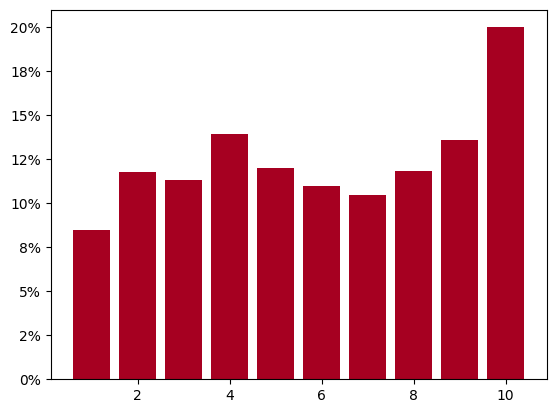

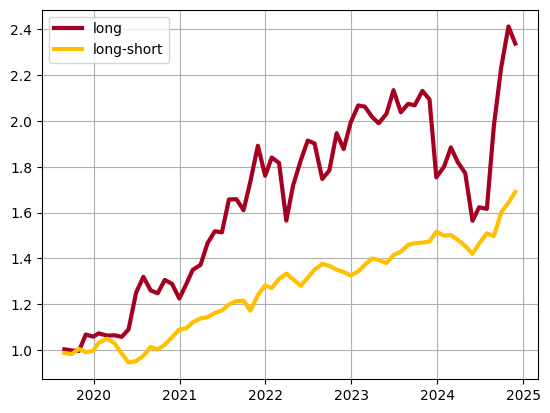

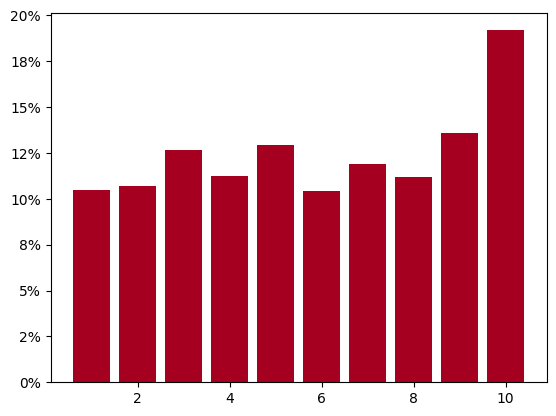

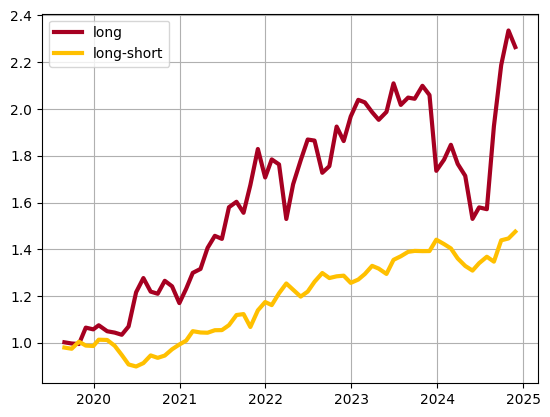

      factor   IC_mean     IC_IR         t       max       min
0  N_connect -0.035486 -0.360439 -2.883510  0.156173 -0.285121
0  N_connect -0.028419 -0.293399 -2.347193  0.164070 -0.267454
      factor  long_annual  long_sharpe  long_short_annual
0  N_connect     0.199730     0.913979           0.106632
0  N_connect     0.191791     0.889911           0.079641


In [13]:
dirname = '../data/N_connect_1_both/'
IC_num, grouped_num = backtest(dirname + '/N_connect_num.feather', 'N_connect', 'N_connect_num')
IC_size, grouped_size = backtest(dirname + '/N_connect_size.feather', 'N_connect', 'N_connect_size')
IC = pd.concat([IC_num, IC_size])
grouped = pd.concat([grouped_num, grouped_size])
print(IC)
print(grouped)

## 跳跃收益因子回测

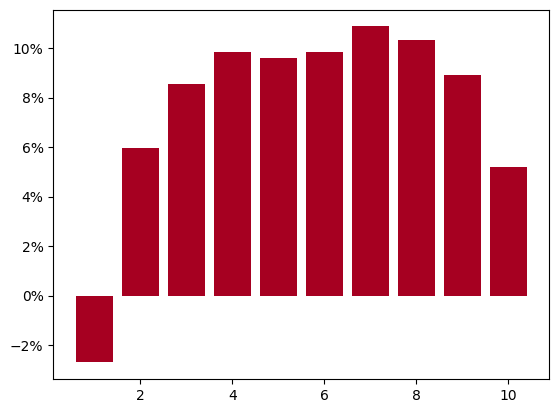

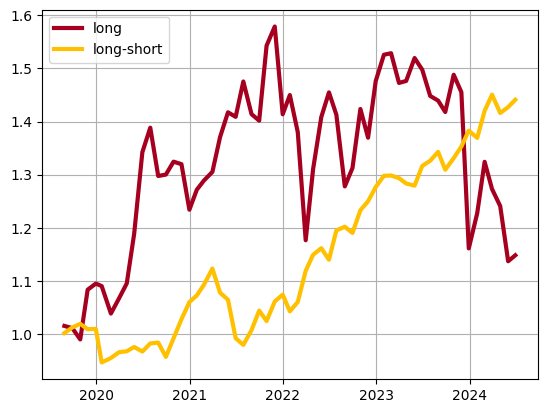

     factor   IC_mean     IC_IR         t       max       min
0  ret_jump -0.037357 -0.655348 -5.033823  0.088623 -0.172599
     factor  long_annual  long_sharpe  long_short_annual
0  ret_jump     0.051796     0.245919           0.080873


In [14]:
IC, grouped = backtest('../data/ret_jump.feather', 'ret_jump')
print(IC)
print(grouped)